## LDA Modeling, No-Gram

In [1]:
#set up sys
import os, sys
sys.path.append('../PMC_func')


#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from collections import Counter

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import ConvergenceMetric
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import pickle
import warnings
warnings.filterwarnings('ignore')

### Import Data
- Pickled Gensim Objects
- Composite Data Frame

In [2]:
nogram_filename = "../pickled_data/nogram_corpus.pkl"
bigram_filename = "../pickled_data/bigram_corpus.pkl"
trigram_filename = "../pickled_data/trigram_corpus.pkl"
df_lemmatized_texts = "../pickled_data/df_lemmatized_texts.pkl"

with open(nogram_filename, "rb") as f:
    nogram_list_lemmatized_texts, nogram_corpus, nogram_id2word = pickle.load(f)

with open(bigram_filename, "rb") as g:
    bigram_list_lemmatized_texts, bi_corpus, bi_id2word = pickle.load(g)
    
with open(trigram_filename, "rb") as h:
    trigram_list_lemmatized_texts, tri_corpus, tri_id2word = pickle.load(h)
    
with open(df_lemmatized_texts, "rb") as m:
    df_lemmatized_texts = pickle.load(m)

In [3]:
# store raw texts as a list for later
df_list = df_lemmatized_texts.text.tolist()

### Gensim LDA modeling - Hyper Parameter Tunning

#### Coherence Score

In [4]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

convergence_logger = ConvergenceMetric(logger='shell')

In [5]:
num_topics_list = list(range(5,20,5))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 4
iterations = 200
eval_every = 1
callbacks = [convergence_logger]

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=nogram_id2word, 
                         num_topics=num_topics,
                         corpus=nogram_corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=nogram_list_lemmatized_texts, dictionary=nogram_id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics, "; score = ", coherence_score)

LDA model/coherence complete for num_topics =  5 ; score =  0.5582239110363021
LDA model/coherence complete for num_topics =  10 ; score =  0.520461885206847
LDA model/coherence complete for num_topics =  15 ; score =  0.48934435840577517


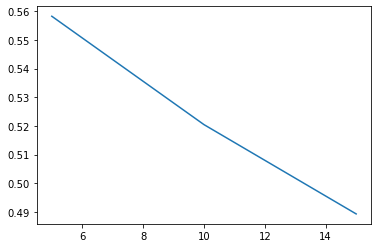

In [6]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution - 5 topics

In [7]:
opt_topic_index = 0
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

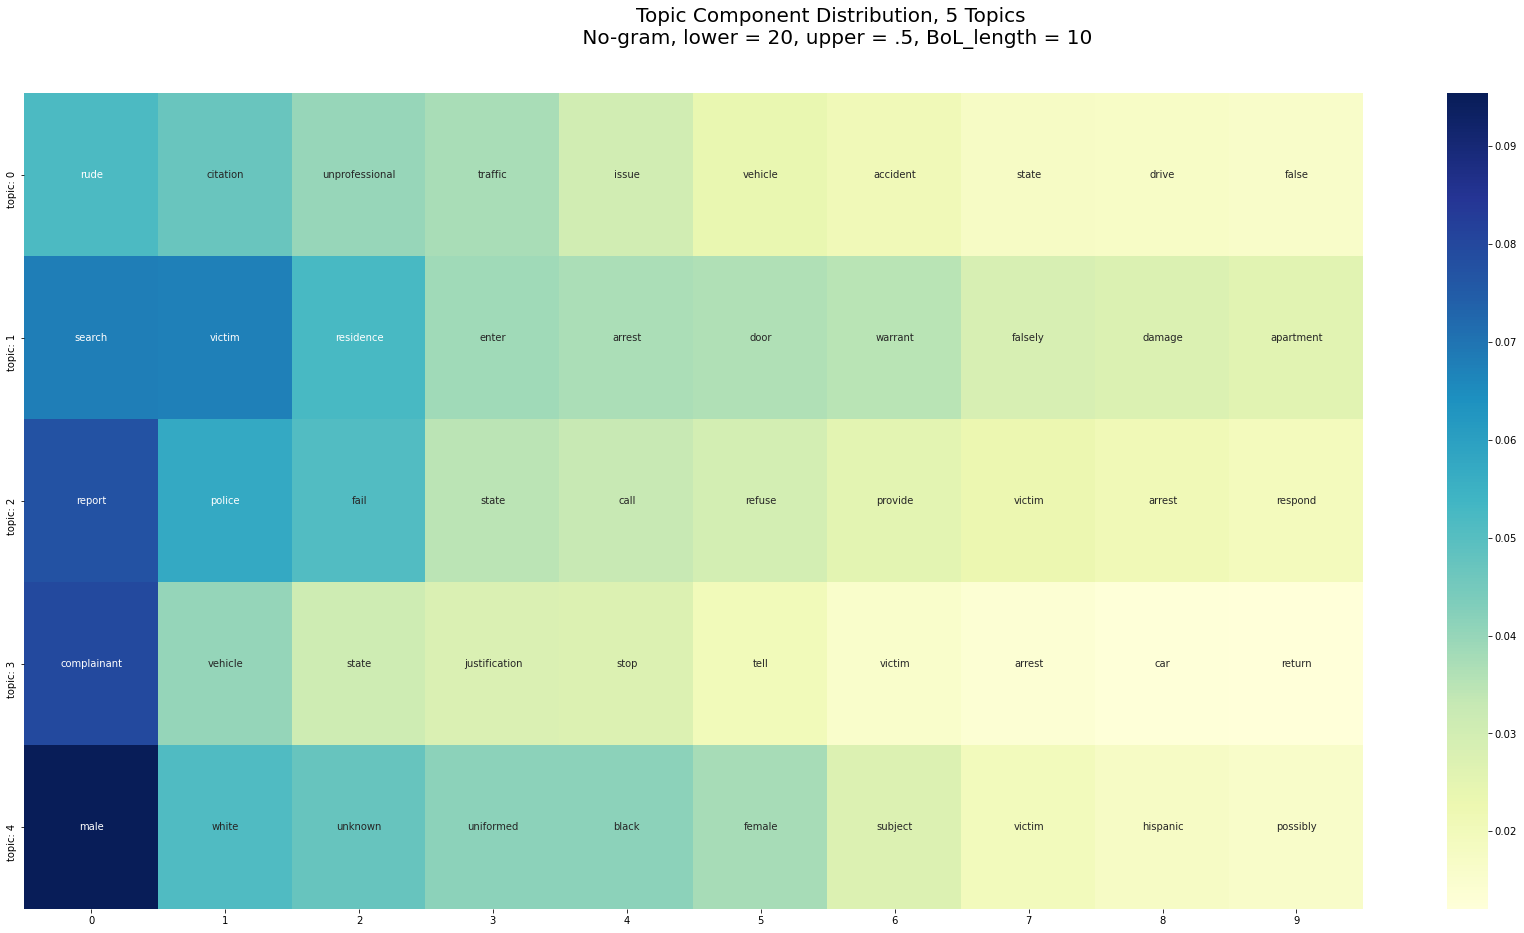

In [8]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_5topics1.png')

#### pyLDAvis Principal Component Visualization

In [9]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_5topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [10]:
dom_topic_df_5 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_5 = PMC_module.return_top_representatives(dom_topic_df_5, num_reps = 10)

In [11]:
top_representatives_5[top_representatives_5['Dominant_Topic'] == 3].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
30,21118,3.0,0.9385,"[complainant, vehicle, state, justification, s...","[reporting, party, allege, accuse, officer, re...",The reporting party alleges that the accused\n...
31,31240,3.0,0.9108,"[complainant, vehicle, state, justification, s...","[complainant, allege, accuse, officer, detain,...",The complainant alleges that the accused\noffi...
32,31241,3.0,0.9108,"[complainant, vehicle, state, justification, s...","[complainant, allege, accuse, officer, detain,...",The complainant alleges that the accused\noffi...
33,31306,3.0,0.9042,"[complainant, vehicle, state, justification, s...","[complainant, allege, accuse, officer, detain,...",The complainant alleges that the accused\noffi...
34,25779,3.0,0.9004,"[complainant, vehicle, state, justification, s...","[complainant, allege, arrest, procedure, accus...",The complainant alleged that during arrest\npr...
35,25778,3.0,0.9004,"[complainant, vehicle, state, justification, s...","[complainant, allege, arrest, procedure, accus...",The complainant alleged that during arrest\npr...
36,26217,3.0,0.8974,"[complainant, vehicle, state, justification, s...","[complainant, unopened, beer, see, accuse, off...",The complainant had an unopened can of\nbeer w...
37,26216,3.0,0.8937,"[complainant, vehicle, state, justification, s...","[complainant, unopened, beer, see, accuse, off...",The complainant had an unopened can of\nbeer w...
38,28910,3.0,0.8923,"[complainant, vehicle, state, justification, s...","[reporting, party, allege, accuse, officer, st...",The Reporting Party alleged that the\naccused ...
39,28909,3.0,0.8923,"[complainant, vehicle, state, justification, s...","[reporting, party, allege, accuse, officer, st...",The Reporting Party alleged that the\naccused ...


In [12]:
topic_of_interest = 3
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_5[top_representatives_5['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 3
---------
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
orretumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retu

#### Topic Component Distribution - 10 topics

In [13]:
opt_topic_index = 1
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

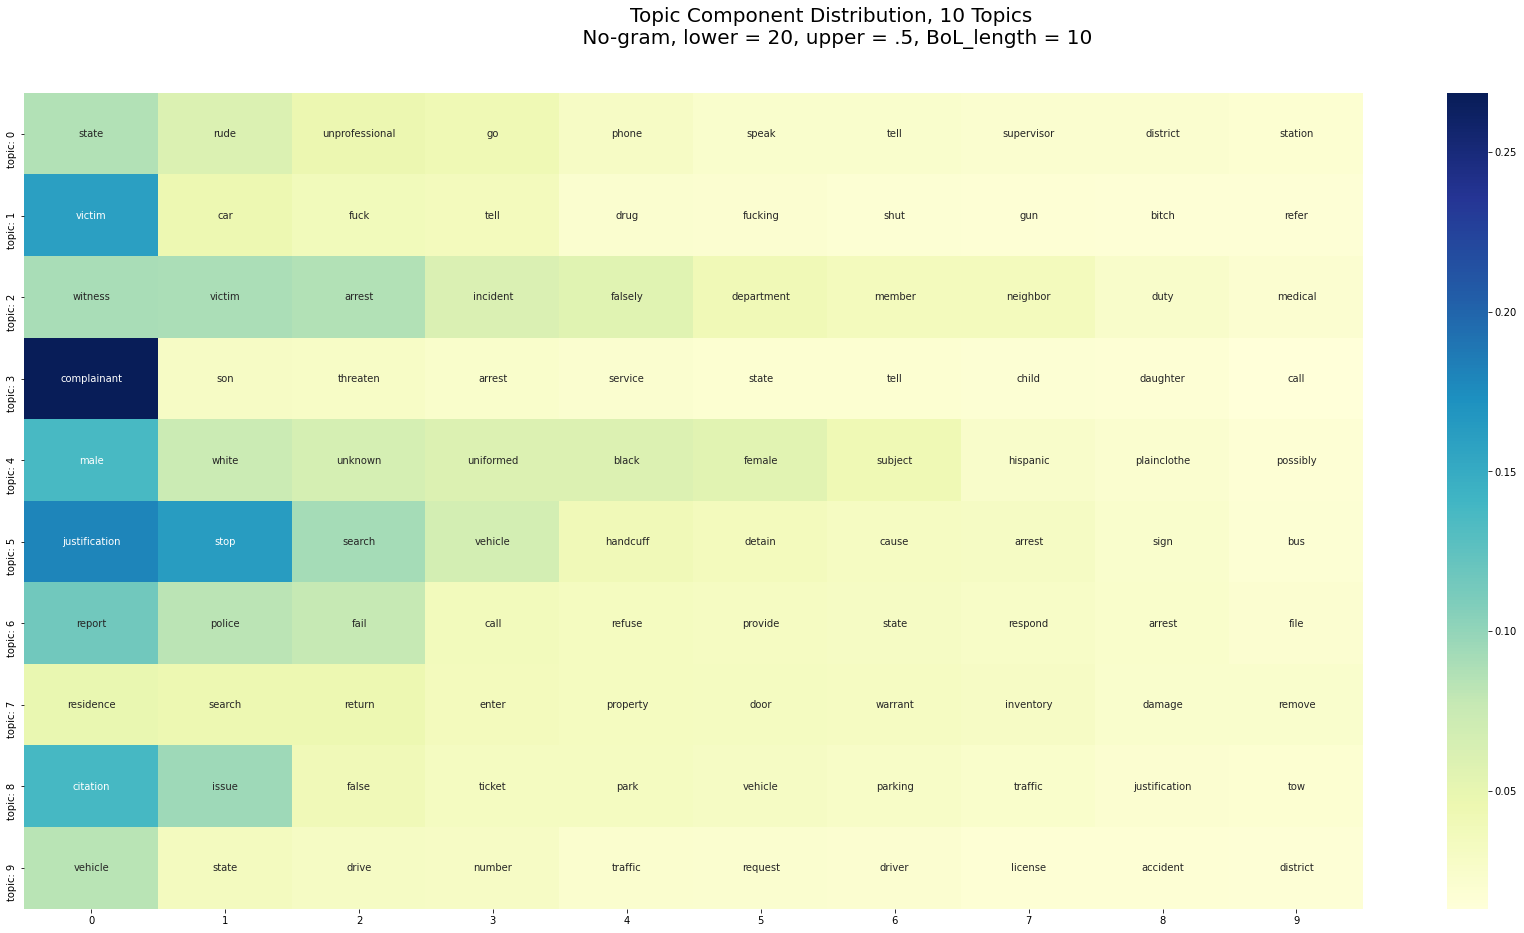

In [14]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 10 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_10topics1.png')

#### pyLDAvis Principal Component Visualization

In [15]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_10topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [16]:
dom_topic_df_10 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_10 = PMC_module.return_top_representatives(dom_topic_df_10, num_reps = 10)

In [17]:
top_representatives_10[top_representatives_10['Dominant_Topic'] == 4].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
40,3654,4.0,0.7260,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, accuse, officer, gr...",THE REPORTING PARTY ALLEGES THAT\nONE OF THE A...
41,30526,4.0,0.7177,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, unknown, black, fem...",The reporting party '\nalleges that an unknown...
42,3173,4.0,0.7170,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, hispanic, male, pla...",The reporting party alleges that a Hispanic\nm...
43,1603,4.0,0.7059,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, lie, face, ground, ...",The reporting party alleges that while he\nwas...
44,30527,4.0,0.6826,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, unkng.r, wiaun, off...",The reporting party\nalleges that an UnkNG.r w...
45,1795,4.0,0.6604,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, accuse, officer, ha...",The reporting party alleged that the accused\n...
46,1602,4.0,0.6514,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, lie, face, ground, ...",The reporting party alleges that while he\nwas...
47,25284,4.0,0.6387,"[male, white, unknown, uniformed, black, femal...","[reporting, party, witness, allege, observe, m...",The reporting party witness alleges that she\...
48,25283,4.0,0.6387,"[male, white, unknown, uniformed, black, femal...","[reporting, party, witness, allege, observe, m...",The reporting party witness alleges that she\...
49,32542,4.0,0.6345,"[male, white, unknown, uniformed, black, femal...","[reporting, party, allege, male, black, plainc...",The reporting party alleges that a male\nblack...


In [18]:
topic_of_interest = 4
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_10[top_representatives_10['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 4
---------
THE REPORTING PARTY ALLEGES THAT
ONE OF THE ACCUSED OFFICERS.
GRABBED HIM, CHOKED HIM AND
SLAMMED HIM DOWN ON THE
CONCRETE. HE ALSO ALLEGES THAT
HE WAS HANDCUFFED TOO TIGHTLY
THE REPORTING PARTY ALLEGES THAT
ONE OF THE ACCUSED OFFICERS
GRABBED HIM, CHOKED HIM AND
SLAMMED HIM DOWN ON THE
CONCRETE. HE ALSO ALLEGES THAT
HE WAS HANDCUFFED TOO TIGHTLY
THE REPORTING PARTY ALLEGES THAT
ONE OF THE ACCUSED OFFICERS
GRABBED HIM, CHOKED HIM AND
SLAMMED HIM DOWN ON THE
CONCRETE. HE ALSO ALLEGES THAT
HE WAS HANDCUFFED TOO TIGHTLY
THE REPORTING PARTY ALLEGES THAT
ONE OF THE ACCUSED OFFICERS.
GRABBED HIM, CHOKED HIM AND
SLAMMED HIM DOWN ON THE
CONCRETE. HE ALSO ALLEGES THAT
HE WAS HANDCUFFED TOO TIGHTLY
------
The reporting party '
alleges that an unknown black female
officer placed her hands around her neck
and choked her without justification; in
addition, the black male officer grabbed and
pushed her to the ground
The reporting party
alleges that an unknown black male officer
st

#### Topic Component Distribution - 15 topics

In [19]:
opt_topic_index = 2
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

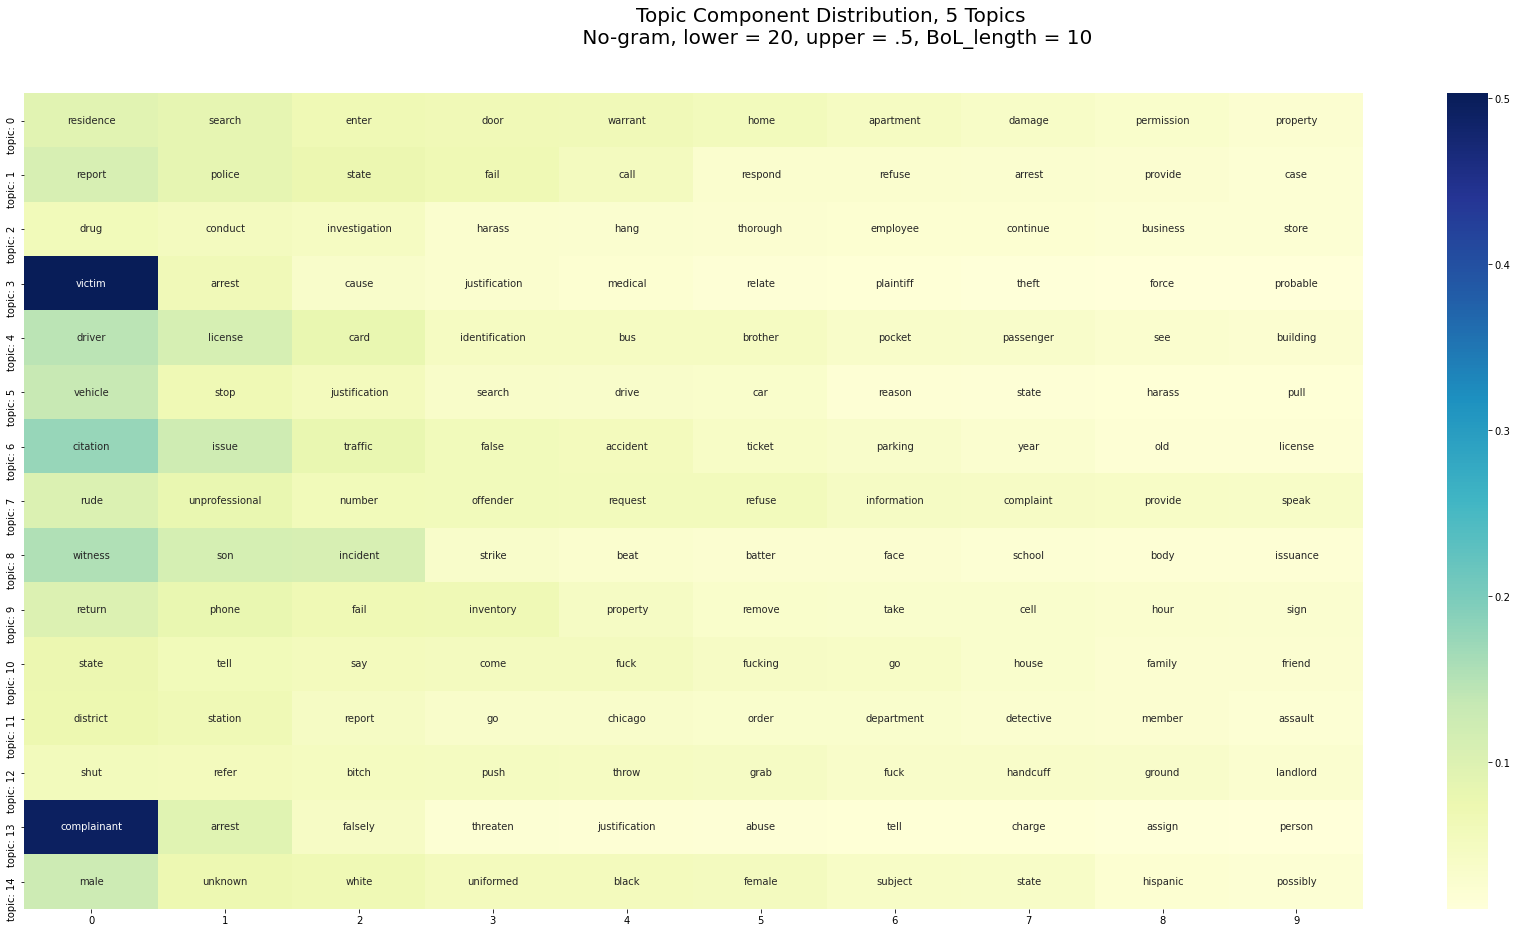

In [20]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n No-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_nogram_15topics1.png')

#### pyLDAvis Principal Component Visualization

In [21]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_nogram_15topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], nogram_corpus, nogram_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [22]:
dom_topic_df_15 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],nogram_corpus, nogram_list_lemmatized_texts,df_list)
top_representatives_15 = PMC_module.return_top_representatives(dom_topic_df_15, num_reps = 10)

In [23]:
top_representatives_15[top_representatives_15['Dominant_Topic'] == 4].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
40,18876,4.0,0.3717,"[driver, license, card, identification, bus, b...","[accuse, ask, taxi, cab, accuse, officer, pock...",the accused\nand asked him\ntaxi cab. The\nthe...
41,5948,4.0,0.3685,"[driver, license, card, identification, bus, b...","[complainant, allege, accuse, officer, remove,...",The complainant alleges that during aw\nthe ac...
42,25382,4.0,0.3658,"[driver, license, card, identification, bus, b...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
43,28280,4.0,0.3364,"[driver, license, card, identification, bus, b...","[reporting, party, allege, justification, accu...",The reporting party alleges that without\njust...
44,6124,4.0,0.3344,"[driver, license, card, identification, bus, b...","[reporting, party, victim, allege, accuse, off...",The reporting party victim alleged that the\na...
45,17641,4.0,0.3290,"[driver, license, card, identification, bus, b...","[complainant, state, accuse, officer, get, bus...",The complainant states that the accused\noffic...
46,4424,4.0,0.3223,"[driver, license, card, identification, bus, b...","[license, insurance, card, item, furthermore, ...",license and insurance card\nthe items. Further...
47,7180,4.0,0.3204,"[driver, license, card, identification, bus, b...","[reporting, victim, allege, accuse, approach, ...",The reporting victim alleged that that\naccuse...
48,17640,4.0,0.3160,"[driver, license, card, identification, bus, b...","[complainant, state, accuse, officer, get, bus...",The complainant states that the accused\noffic...
49,9803,4.0,0.3134,"[driver, license, card, identification, bus, b...","[complainant, allege, accuse, officer, stop, f...",The complainant alleged that the accused\noffi...


In [24]:
topic_of_interest = 4
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_15[top_representatives_15['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 4
---------
the accused
and asked him
taxi cab. The
the accused officer
pockets, threw
his pocket to the
falsely cited
took his Driver's
------
The complainant alleges that during aw
the accused officers removed $450.00, ;
credit card, a bank card and miscellanec
identification cards that were not invent
retumed.
------
THE REPORTING PARTY ALLEGES THAT
THE ACCUSED OFFICER STOPPED HIM
WITHOUT JUSTIFICATION AND THREW
HIS INSURANCE CARD AND HIS
LICENSE AT HIM
------
The reporting party alleges that without
justification the accused officer issued her
three traffic citations and threw her driver's
license in the driver side window of the
reporting party's vehicle when the officer
returned the license.
------
The reporting party victim alleged that the
accused officer failed to return her card
holder containing her drivers license,
Statefarm insurance card, Blue Cross/Blue
Shield medical card and a Rush debit card.
The reporting party victim alleged that the
accused officer failed to